In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import scipy as sp
import sys,os
sys.path.append('../vmPAC/vmPAC_code/')  #for vmPAC_v2 and CFC
sys.path.append('../gammaPAC/')          #for gammaPAC  
sys.path.append('../admmCode/python')
from gammaPAC.gammaPAC import *
import vmPAC_v2
import CFC
from CFC import *
from ss_gamma import *
from multiprocessing import Pool, cpu_count
from joblib import Parallel, delayed
import mne
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs
np.random.seed(0)

In [7]:
baseDir = '/Users/andrewperley/Desktop/Lab Stuff/Stanford/Gut-Brain/Data/'
exp = 'Smell'
subj_list = os.listdir(baseDir + exp + '/')
subj_num = 12
#find the string in subj_list that contains the 'patient'+subj_num
subj = [s for s in subj_list if 'patient'+str(subj_num) in s][0]
dataDir = baseDir + exp + '/' + subj + '/'
saveDir = dataDir + 'dataDeriv/'
if not os.path.exists(saveDir):
    os.makedirs(saveDir)
print(subj)

patient12_20231218_093617


In [8]:
fs = 125

methodsAR = ['ica','eogReg','raw']
methodAR = methodsAR[1]
start = 2
stop = 12

#load EEG data
dataEEG = np.load(dataDir + f'{subj}_EEG_{methodAR}_{start}-{stop}min.npy')
#dataEEG = np.load(dataDir + f'{subj}_EEG_eogReg_2-12min.npy')

if methodAR != 'ica':
    dataEEG = dataEEG*1e6


#load EGG data
matEGG = sp.io.loadmat(dataDir + f'{subj}_EGG_preprocessed.mat')
dataEGG = np.squeeze(matEGG['bestEGG'])
dataEGG = sp.signal.decimate(dataEGG, 2)
dataEGG = dataEGG[start*60*fs:stop*60*fs]

channel_names = [f'E{i}' for i in range(1,129)]
info = mne.create_info(ch_names=channel_names, sfreq=fs, ch_types=['eeg']*(dataEEG.shape[0]-1))
info.set_montage('GSN-HydroCel-128');

In [9]:
#write a function to plot PAC topoplot
def plot_PAC_topoplot(values,info,fig_name,ax_title = 'Z-scored MI',fsave = True,vlim = (-5,5),reduce = True):
  if reduce:
    eeg_indices = mne.pick_types(info, meg=False, eeg=True)
    eeg_indices = np.delete(eeg_indices,[47,48,112,118,125,126])
    info = mne.pick_info(info, eeg_indices)
    try:
      values = np.delete(values,[47,48,112,118,125,126,128])
    except:
      values = np.delete(values,[47,48,112,118,125,126])

  

  fig,ax1 = plt.subplots(ncols=1)
  im,cn = mne.viz.plot_topomap(values,info,ch_type = 'eeg',
                              image_interp = 'cubic',extrapolate='local',size = 5,cmap = 'jet',axes=ax1,show=False,
                              vlim = vlim)

  ax_x_start = 0.95
  ax_x_width = 0.04
  ax_y_start = 0.1
  ax_y_height = 0.9
  cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
  clb = fig.colorbar(im, cax=cbar_ax)
  clb.ax.set_title(ax_title) # title on top of colorbar
  #set colorbar limits
  fig.subplots_adjust(wspace=.05)
  if fsave:
    #lgd = ax1.legend()
    #plt.savefig(fig_name,bbox_extra_artists=(lgd,),bbox_inches='tight')
    plt.savefig(fig_name,bbox_inches='tight')

## pac data

In [10]:
def compute_pvals(values,surrogates):
    pvals = np.zeros((values.shape[0],))
    for i in range(values.shape[0]):
        if np.isnan(values[i]) or np.isnan(surrogates[i]).all():
            pvals[i] = 1#np.nan
        else:
            pvals[i] = np.sum(surrogates[i]>values[i])/surrogates[i].shape[0]
            #alpha, loc, scale = sp.stats.gamma.fit(surrogates[i],floc=0)
            #pvals[i] = 1 - sp.stats.gamma.cdf(values[i],alpha,loc=loc,scale=scale)
        
    return pvals

def holm_procedure(pvals,alpha=0.05,fPlot = True):
    n = len(pvals)
    sort_idx = np.argsort(pvals)
    pvals_sorted = pvals[sort_idx]

    pvals_holm = np.zeros((n,))
    for i in range(n):
        pvals_holm[i] = min(pvals_sorted[i]*(n-i),1)
    
    #step-down procedure to find the largest k such that all p(k) for 1,...,k <= alpha
    k = 0
    for i in range(n):
        if pvals_sorted[i] <= alpha/(n-i):
            k = i
        else:
            break
    #print(f'k = {k+1}')
    
    if fPlot:
        plt.scatter(np.arange(1,n+1),pvals_holm,s = 1,marker='*')
        plt.plot(np.arange(1,n+1),alpha*np.ones((n,)),'--',color = 'tab:orange',label = f'α = {alpha}')
        #plt.scatter(np.arange(1,n+1),pvals_sorted,s = 1,marker='*')
        #plt.plot(np.arange(1,n+1),alpha*np.arange(1,n+1)/n,'--',color = 'tab:orange')
        plt.axvline(k+1,linestyle='--',color='tab:red',label = f'crit-value = {k+1}')
        plt.xlabel('Sorted index')
        plt.ylabel('Holm adjusted p-value')
        plt.title('Holm Procedure')
        plt.legend(loc = 'lower right')

    return pvals_holm,sort_idx,k

def bh_procedure(pvals,alpha=0.05,fPlot = True):
    n = len(pvals)
    sort_idx = np.argsort(pvals)
    pvals_sorted = pvals[sort_idx]

    pvals_bh = np.zeros((n,))
    for i in range(n):
        pvals_bh[i] = min(pvals_sorted[i]*n/(i+1),1)
    
    #step-up procedure to find the largest k such that p(k) <= alpha*k/n
    k = -1
    for i in range(n):
        if pvals_sorted[i] <= alpha*(i+1)/n:
            k = i
    #print(f'k = {k+1}')
    
    if fPlot:
        plt.scatter(np.arange(1,n+1),pvals_bh,s = 1,marker='*')
        plt.plot(np.arange(1,n+1),alpha*np.ones((n,)),'--',color = 'tab:orange',label = f'α = {alpha}')
        #plt.scatter(np.arange(1,n+1),pvals_sorted,s = 1,marker='*')
        #plt.plot(np.arange(1,n+1),alpha*np.arange(1,n+1)/n,'--',color = 'tab:orange')
        plt.axvline(k+1,linestyle='--',color='tab:red',label = f'crit-value = {k+1}')
        plt.xlabel('Sorted index')
        plt.ylabel('BH adjusted p-value')
        plt.title('Benjamini-Hochberg Procedure')
        plt.legend(loc = 'lower right')

    return pvals_bh,sort_idx,k

def by_procedure(pvals,alpha=0.05,fPlot = True):
    n = len(pvals)
    Sn = np.sum(1/np.arange(1,n+1))
    sort_idx = np.argsort(pvals)
    pvals_sorted = pvals[sort_idx]

    pvals_by = np.zeros((n,))
    for i in range(n):
        pvals_by[i] = min(pvals_sorted[i]*n*Sn/(i+1),1)
    
    #step-up procedure to find the largest k such that p(k) <= alpha*k/n
    k = -1
    for i in range(n):
        if pvals_sorted[i] <= alpha*(i+1)/(n*Sn):
            k = i
    #print(f'k = {k+1}')
    
    if fPlot:
        plt.scatter(np.arange(1,n+1),pvals_by,s = 1,marker='*')
        plt.plot(np.arange(1,n+1),alpha*np.ones((n,)),'--',color = 'tab:orange',label = f'α = {alpha}')
        #plt.scatter(np.arange(1,n+1),pvals_sorted,s = 1,marker='*')
        #plt.plot(np.arange(1,n+1),alpha*np.arange(1,n+1)/n,'--',color = 'tab:orange')
        plt.axvline(k+1,linestyle='--',color='tab:red',label = f'crit-value = {k+1}')
        plt.xlabel('Sorted index')
        plt.ylabel('BY adjusted p-value')
        plt.title('Benjamini-Yekutieli Procedure')
        plt.legend(loc = 'lower right')

    return pvals_by,sort_idx,k

def resort(data,sort_idx):
    new_data = np.zeros(data.shape)
    for i,idx in enumerate(sort_idx):
        new_data[idx] = data[i]
    return new_data

In [11]:
## load data
subjs = [12,13]
mat_files = []

for subj_num in subjs:
    subj = [s for s in subj_list if 'patient'+str(subj_num) in s][0]
    dataDir = baseDir + exp + '/' + subj + '/'
    saveDir = dataDir + 'dataDeriv/'
    mat = sp.io.loadmat(saveDir + f'{subj}_PAC_MI_{methodAR}_{start}-{stop}.mat')
    mat_files.append(mat)
mat.keys()
pac_methods = ['mi','pac']

In [12]:
#compute p-values for each subject and method
pvals_list = []
for i,mat in enumerate(mat_files):
    pac_method = pac_methods[i]
    if pac_method == 'mi':
        values = mat['mi_values'].flatten()
        surrogates = mat['mi_surrogates']
    elif pac_method == 'pac':
        values = mat['pac_values'].flatten()
        surrogates = mat['pac_surrogates']
    pvals_list.append(compute_pvals(values[:128],surrogates[:128]))


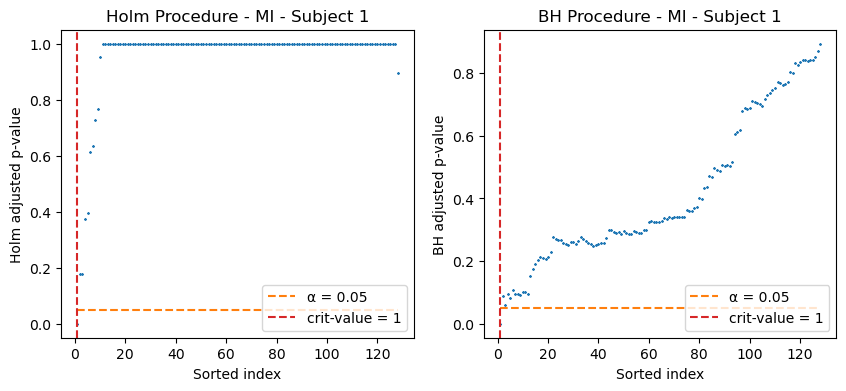

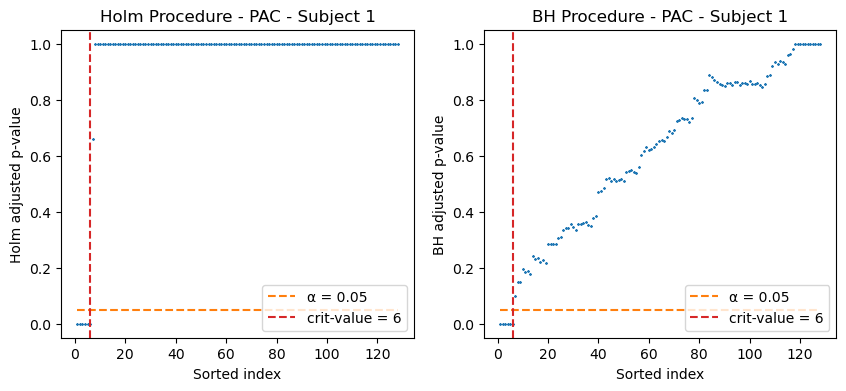

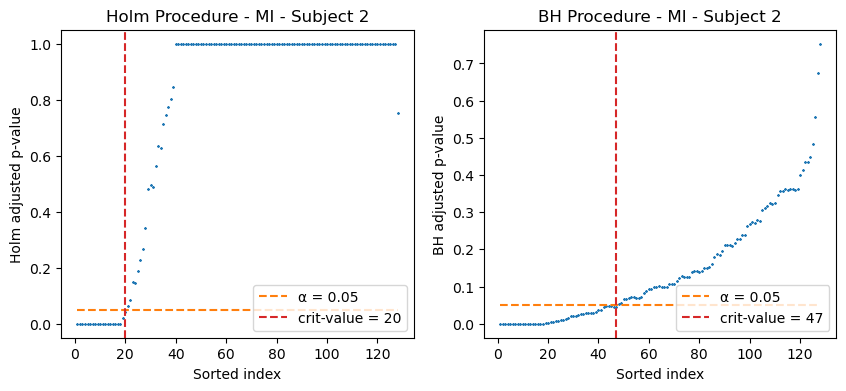

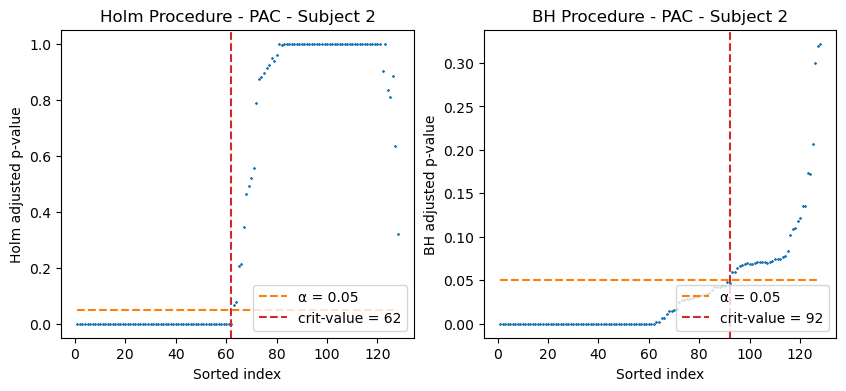

In [15]:
## plot both bh and holm procedures for each subject and method
alpha = 0.05
bh_idces = []
holm_idces = []
pvals_bh_list = []
pvals_holm_list = []

for i,mat in enumerate(mat_files):
    subj_num = i+1
    for m in pac_methods:
        if m == 'mi':
            values = mat['mi_values'].flatten()
            surrogates = mat['mi_surrogates']
        elif m == 'pac':
            values = mat['pac_values'].flatten()
            surrogates = mat['pac_surrogates']
        pvals = compute_pvals(values[:128],surrogates[:128])
        pvals_holm,sort_idx_holm,k_holm = holm_procedure(pvals,alpha=alpha,fPlot = False)
        pvals_bh,sort_idx_bh,k_bh = bh_procedure(pvals,alpha=alpha,fPlot = False)

        bh_idces.append(sort_idx_bh)
        holm_idces.append(sort_idx_holm)
        pvals_bh_list.append(pvals_bh)
        pvals_holm_list.append(pvals_holm)

        fig,ax = plt.subplots(ncols=2,figsize=(10,4))
        ax[0].scatter(np.arange(1,129),pvals_holm,s = 1,marker='*')
        ax[0].plot(np.arange(1,129),alpha*np.ones((128,)),'--',color = 'tab:orange',label = f'α = {alpha}')
        ax[0].axvline(k_holm+1,linestyle='--',color='tab:red',label = f'crit-value = {k_holm+1}')
        ax[0].set_xlabel('Sorted index')
        ax[0].set_ylabel('Holm adjusted p-value')
        ax[0].set_title(f'Holm Procedure - {m.upper()} - Subject {subj_num}')
        ax[0].legend(loc = 'lower right')

        ax[1].scatter(np.arange(1,129),pvals_bh,s = 1,marker='*')
        ax[1].plot(np.arange(1,129),alpha*np.ones((128,)),'--',color = 'tab:orange',label = f'α = {alpha}')
        ax[1].axvline(k_bh+1,linestyle='--',color='tab:red',label = f'crit-value = {k_bh+1}')
        ax[1].set_xlabel('Sorted index')
        ax[1].set_ylabel('BH adjusted p-value')
        ax[1].set_title(f'BH Procedure - {m.upper()} - Subject {subj_num}')
        ax[1].legend(loc = 'lower right')

        plt.savefig(f'{subj_num+11}_{m}_multiple_comparisons.svg',bbox_inches='tight')



In [219]:
mat['mi_z_scores'].flatten()[:128].shape

(128,)

In [220]:
mat['mi_values'].flatten()[16]

0.0015418677214887096

In [221]:
pvals_list[0][16]

0.7838

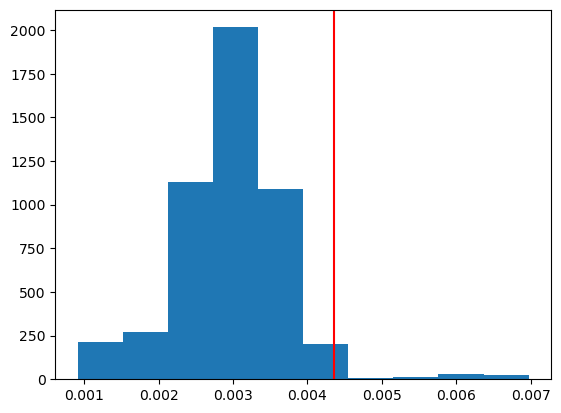

In [222]:
plt.hist(mat['mi_surrogates'][17])
plt.axvline(mat['mi_values'].flatten()[17],color='r')

In [223]:
pvals_list[0]

array([0.0284, 0.0088, 0.0552, 0.0718, 0.5676, 0.8058, 0.6106, 0.1592,
       0.1028, 0.1896, 0.3336, 0.7946, 0.6712, 0.1944, 0.1266, 0.1354,
       0.7838, 0.2252, 0.682 , 0.7678, 0.3332, 0.0224, 0.4554, 0.7288,
       0.2138, 0.821 , 0.837 , 0.863 , 0.8026, 0.816 , 0.5306, 0.8938,
       0.6722, 0.7676, 0.6466, 0.7314, 0.6934, 0.6688, 0.5274, 0.6354,
       0.5618, 0.3612, 0.0156, 0.6226, 0.3114, 0.3608, 0.3756, 0.0588,
       0.009 , 0.3098, 0.352 , 0.1622, 0.152 , 0.57  , 0.003 , 0.1812,
       0.3356, 0.175 , 0.1814, 0.1568, 0.1562, 0.0792, 0.5136, 0.1864,
       0.1374, 0.118 , 0.2124, 0.2156, 0.116 , 0.0378, 0.0612, 0.0736,
       0.1264, 0.052 , 0.0014, 0.0712, 0.0722, 0.062 , 0.0844, 0.4446,
       0.1912, 0.0726, 0.0308, 0.1048, 0.1098, 0.0662, 0.3542, 0.278 ,
       0.2832, 0.1244, 0.0504, 0.0734, 0.0768, 0.4634, 0.229 , 0.1748,
       0.117 , 0.0922, 0.5646, 0.251 , 0.251 , 0.1064, 0.0522, 0.0334,
       0.1658, 0.594 , 0.1054, 0.0826, 0.006 , 0.019 , 0.1292, 0.1974,
      

In [224]:
resort(pvals_holm_list[2*s],holm_idces[2*s])

array([1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 0.8938,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 0.375 , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 0.1764, 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 0.726 , 1.    , 1.    , 1.    ,
      

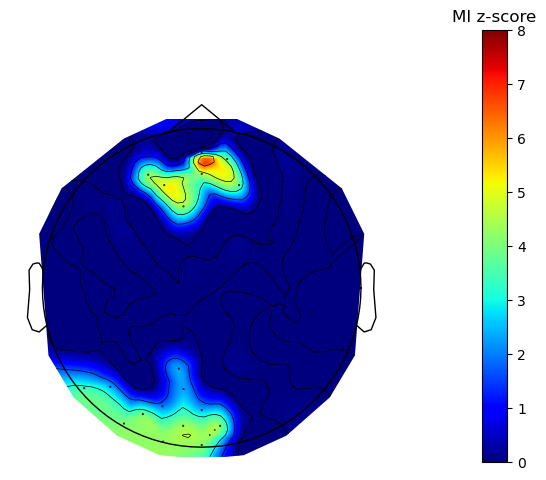

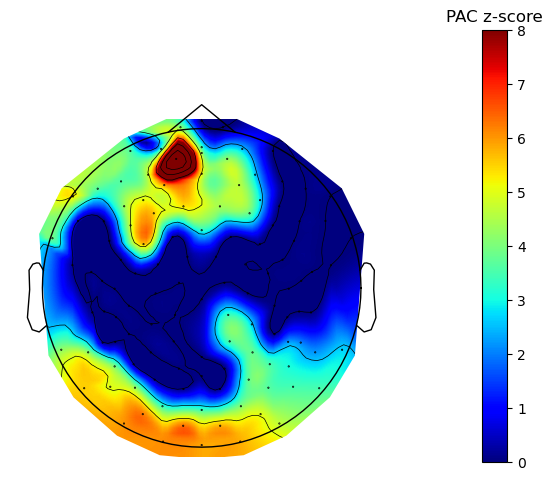

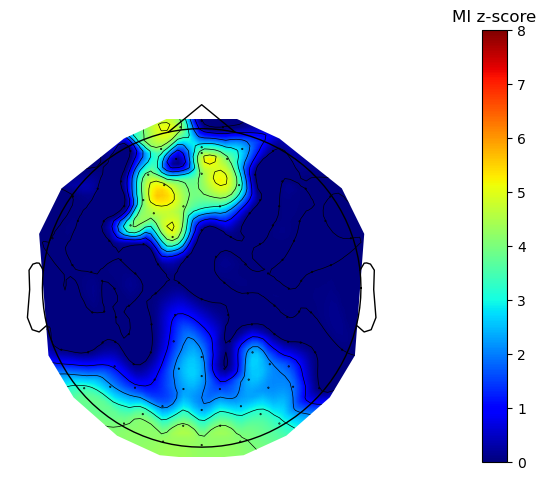

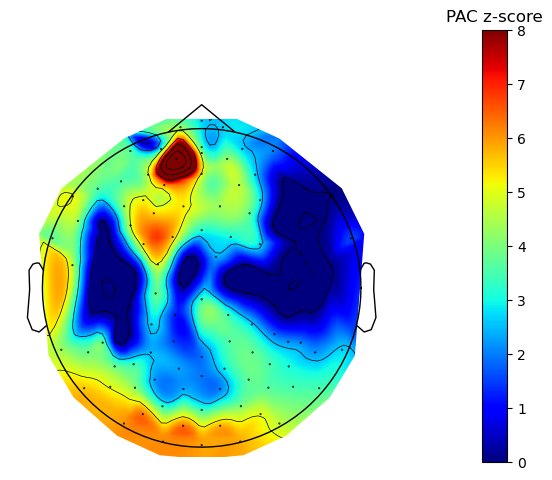

In [245]:
s = 1
mat=mat_files[s]

plotidx1 = resort(pvals_holm_list[2*s],holm_idces[2*s])<.05
plotidx2 = resort(pvals_holm_list[2*s+1],holm_idces[2*s+1])<.05

plot_score1 = mat['mi_z_scores'].flatten()[:128]
plot_score1[~plotidx1] = 0
plot_score2 = mat['pac_z_scores'].flatten()[:128]
plot_score2[~plotidx2] = 0

plot_PAC_topoplot(plot_score1,info,f"patient{s+12}_mi_holm_pval_topo.svg",ax_title = 'MI z-score',fsave = True,vlim = (0,8),reduce = True)
plot_PAC_topoplot(plot_score2,info,f"patient{s+12}_pac_holm_pval_topo.svg",ax_title = "PAC z-score",fsave = True,vlim = (0,8),reduce = True)

plotidx1 = resort(pvals_bh_list[2*s],bh_idces[2*s])<.05
plotidx2 = resort(pvals_bh_list[2*s+1],bh_idces[2*s+1])<.05

plot_score1 = mat['mi_z_scores'].flatten()[:128]
plot_score1[~plotidx1] = 0
plot_score2 = mat['pac_z_scores'].flatten()[:128]
plot_score2[~plotidx2] = 0

plot_PAC_topoplot(plot_score1,info,f"patient{s+12}_mi_bh_pval_topo.svg",ax_title = 'MI z-score',fsave = True,vlim = (0,8),reduce = True)
plot_PAC_topoplot(plot_score2,info,f"patient{s+12}_pac_bh_pval_topo.svg",ax_title = "PAC z-score",fsave = True,vlim = (0,8),reduce = True)

In [ ]:
from scipy.stats import gaussian_kde,ks_2samp
class KDEDist(sp.stats.rv_continuous):
    
    def __init__(self, kde, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._kde = kde
    
    def _pdf(self, x):
        return self._kde.pdf(x)


ch = 89
kde = stats.gaussian_kde(pac_surrogates[ch])
print(stats.ks_2samp(pac_surrogates[ch], X.rvs(size=1000)))

X = KDEDist(kde)
fig,ax = plt.subplots()
x = np.linspace(0,1e-2,100)

ax.hist(pac_surrogates[ch],bins = 100,density = True)
ax.plot(x,X.pdf(x))
ax2 = ax.twinx()
ax2.plot(x,X.cdf(x),color = "tab:green")

print(1-X.cdf(pac_values[ch]))
print(pvals_pac[ch])
ax.axvline(pac_values[ch],color='tab:red',ls = '--')

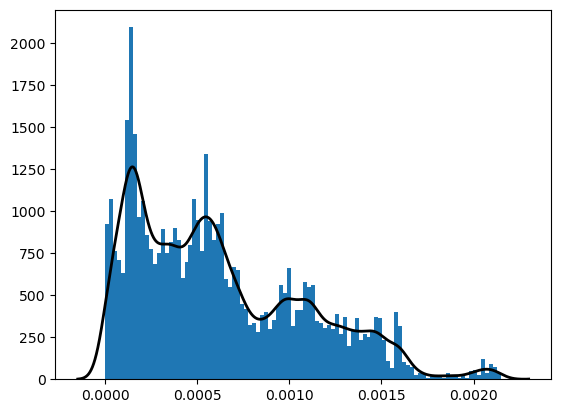

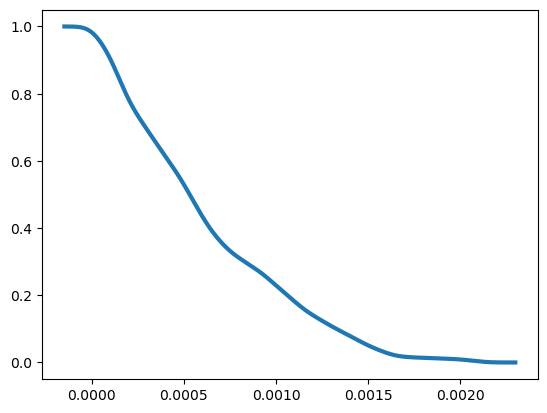

In [115]:
import statsmodels.api as sm

obs_dist = pac_surrogates[ch]
kde = sm.nonparametric.KDEUnivariate(obs_dist)
kde.fit(bw = 5e-5)  # Estimate the densities

fig, ax = plt.subplots()
ax.hist(obs_dist, bins=100, density=True)
ax.plot(kde.support, kde.density, lw=2, color='k')

fig, ax = plt.subplots()
ax.plot(kde.support, kde.sf, lw=3, label="Survival function")



## Comodulograms

LFP_HFO_comodulogram_MI.npy
LFP_HFO_comodulogram_gammaPAC.npy
LFP_HG_comodulogram_MI.npy
LFP_HG_comodulogram_gammaPAC.npy
surrogate_comodulograms.mat

In [9]:
pwd

'/Users/andrewperley/Desktop/Lab Stuff/Stanford/Gut-Brain/Code/analysis'

In [230]:
'''
LFP_HFO_comodulogram_MI.npy
LFP_HFO_comodulogram_gammaPAC.npy
LFP_HG_comodulogram_MI.npy
LFP_HG_comodulogram_gammaPAC.npy
surrogate_comodulograms.mat
'''

#load comodulogram data
comod_dir = '../gammaPAC/testing/Data_Deriv/Tort'


hfo_pac_comod = np.load(comod_dir + '/LFP_HFO_comodulogram_gammaPAC.npy')
hfo_mi_comod = np.load(comod_dir + '/LFP_HFO_comodulogram_MI.npy')
hg_pac_comod = np.load(comod_dir + '/LFP_HG_comodulogram_gammaPAC.npy')
hg_mi_comod = np.load(comod_dir + '/LFP_HG_comodulogram_MI.npy')

surrogate_comodulograms = sp.io.loadmat(comod_dir + '/surrogate_comodulograms.mat')
comods = [hg_mi_comod,hg_pac_comod,hfo_mi_comod,hfo_pac_comod]
keys = ['MI_HG_surrs', 'PAC_HG_surrs', 'MI_HFO_surrs', 'PAC_HFO_surrs']

names = ['High Gamma MI','High Gamma PAC','HFO MI','HFO PAC']

In [231]:
#compute p-values for comodulograms
pvals_comod = []
for i,comod in enumerate(comods):
    surrs = surrogate_comodulograms[keys[i]]
    pvals = np.zeros(comod.shape)
    for j in range(comod.shape[0]):
        for k in range(comod.shape[1]):
            # if np.isnan(comod[j,k]) or np.isnan(surrs[j,k]).all():
            #     pvals[j,k] = 1
            # else:
            #     pvals[j,k] = np.sum(surrs[j,k]>comod[j,k])/surrs[j,k].shape[0]
            #fit gamma distribution to surrogate data
            a, loc, scale = sp.stats.gamma.fit(surrs[j,k],floc=0)
            #compute p-value
            pvals[j,k] = sp.stats.gamma.sf(comod[j,k],a,loc,scale) #1-sp.stats.gamma.cdf(comod[j,k],a,loc,scale)
            res = sp.stats.kstest(surrs[j,k],'gamma',args=(a,loc,scale))
            #res = sp.stats.ks_2samp(surrs[j,k],sp.stats.gamma.rvs(a,loc,scale,size=1000))
            if res.pvalue < 0.05:
                print(f'KS test failed for {names[i]} at {j},{k}. p-value = {res.pvalue}')
            
    pvals_comod.append(pvals)


KS test failed for High Gamma PAC at 11,7. p-value = 0.03947266749269607
KS test failed for HFO MI at 11,2. p-value = 0.04529961788935655
KS test failed for HFO MI at 26,7. p-value = 0.04760529852298934
KS test failed for HFO PAC at 11,3. p-value = 0.04788933527623318


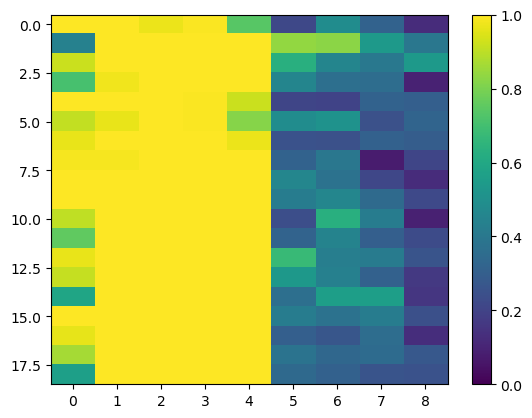

In [232]:
plt.imshow(1-pvals_comod[1],aspect = 'auto',vmin=0,vmax=1)
plt.colorbar()

(array([22., 18., 15., 10., 11.,  9.,  2.,  4.,  3.,  0.,  2.,  0.,  1.,
         1.,  2.]),
 array([4.54799445e-07, 1.56912042e-06, 2.68344140e-06, 3.79776237e-06,
        4.91208335e-06, 6.02640433e-06, 7.14072530e-06, 8.25504628e-06,
        9.36936726e-06, 1.04836882e-05, 1.15980092e-05, 1.27123302e-05,
        1.38266512e-05, 1.49409721e-05, 1.60552931e-05, 1.71696141e-05]),
 <BarContainer object of 15 artists>)

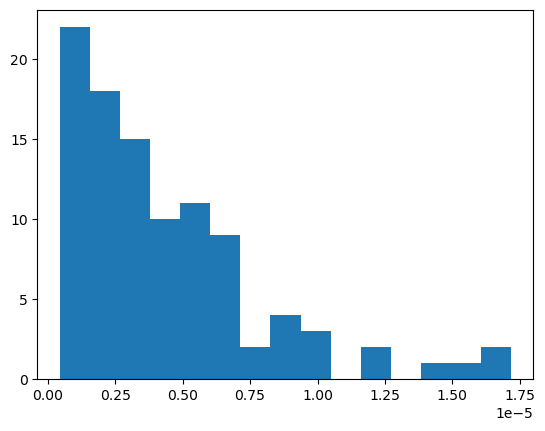

In [233]:
plt.hist(surrogate_comodulograms[keys[2]][:,8,4],bins = 15)

In [234]:
lband = [.5,20.5]
hbands = [[.5,100.5],[.5,150.5]]

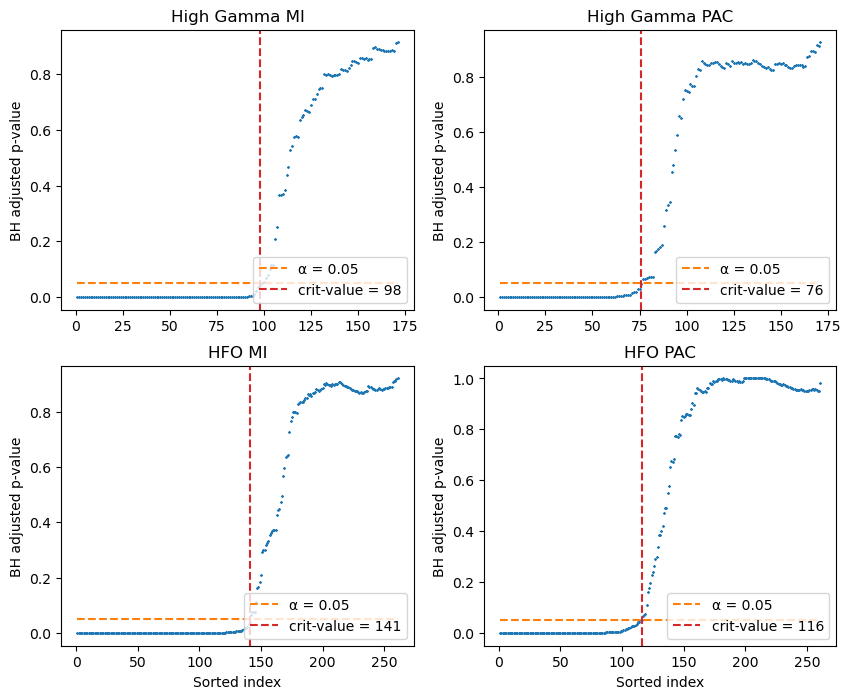

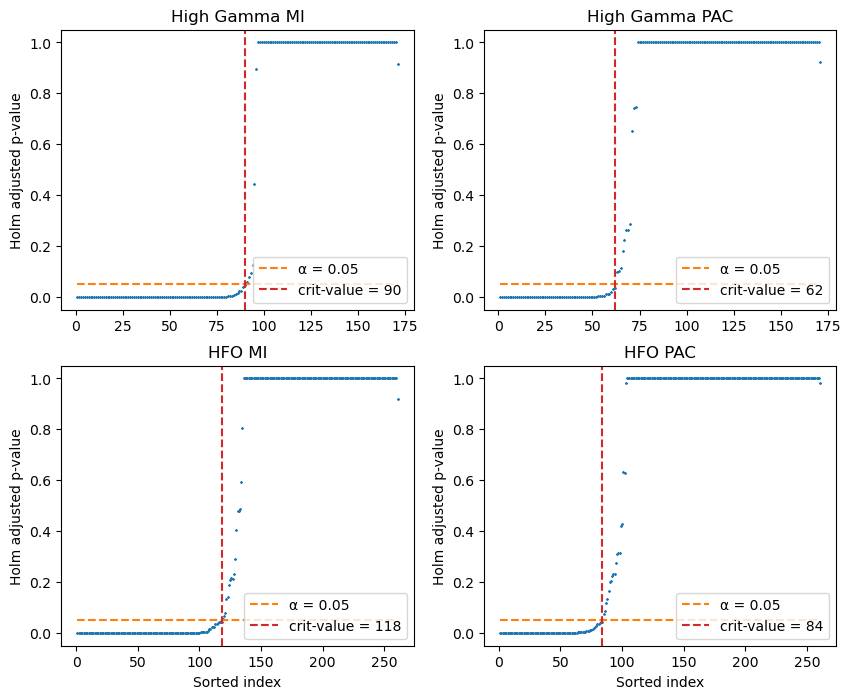

In [235]:
plt.subplots(2,2,figsize=(10,8))

#plot all comodulogram bh procedure
for i in range(4):
    plt.subplot(2,2,i+1)
    pvals_bh, bh_idx, k = bh_procedure(pvals_comod[i].flatten(),alpha = 0.05,fPlot = True)
    plt.title(f'{names[i]}')
    if i == 0 or i ==1:
        plt.xlabel('')

#plt.savefig('../gammaPAC/testing/Figures/comod_bh_pvals.svg')

# do this for the holm procedure
plt.subplots(2,2,figsize=(10,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    pvals_holm, holm_idx, k = holm_procedure(pvals_comod[i].flatten(),alpha = 0.05,fPlot = True)
    plt.title(f'{names[i]}')
    if i == 0 or i ==1:
        plt.xlabel('')
    #ax[i].imshow(comod[i])
#plt.savefig('../gammaPAC/testing/Figures/comod_holm_pvals.svg')

High Gamma MI: 98 significant points
High Gamma PAC: 76 significant points
HFO MI: 141 significant points
HFO PAC: 116 significant points
High Gamma MI: 90 significant points
High Gamma PAC: 62 significant points
HFO MI: 118 significant points
HFO PAC: 84 significant points


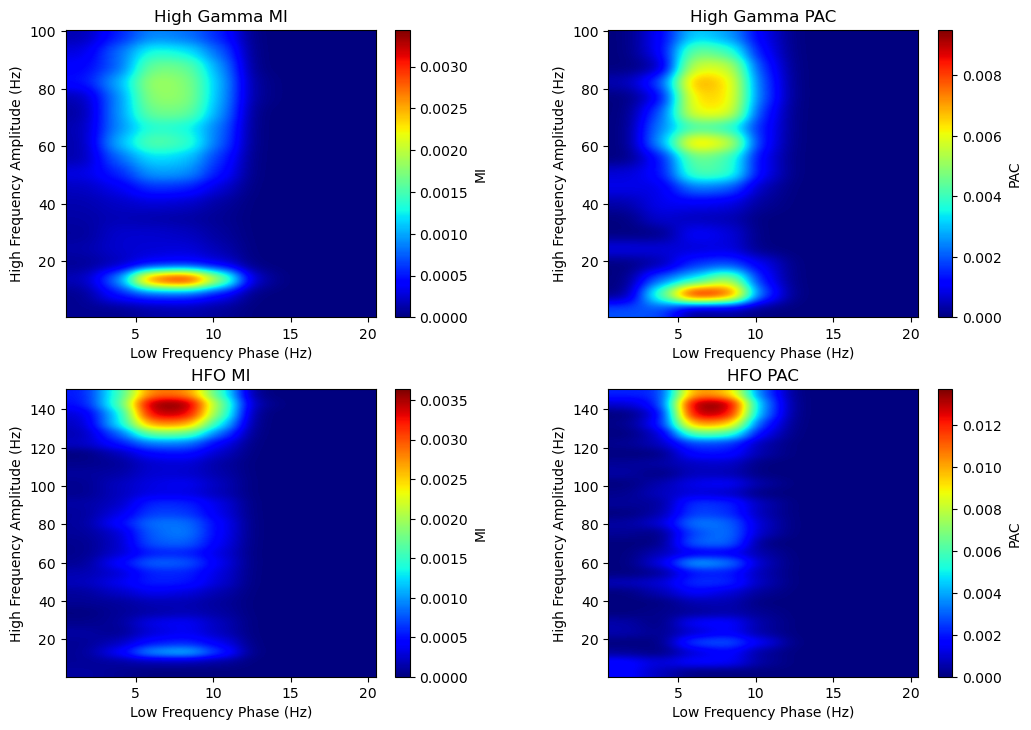

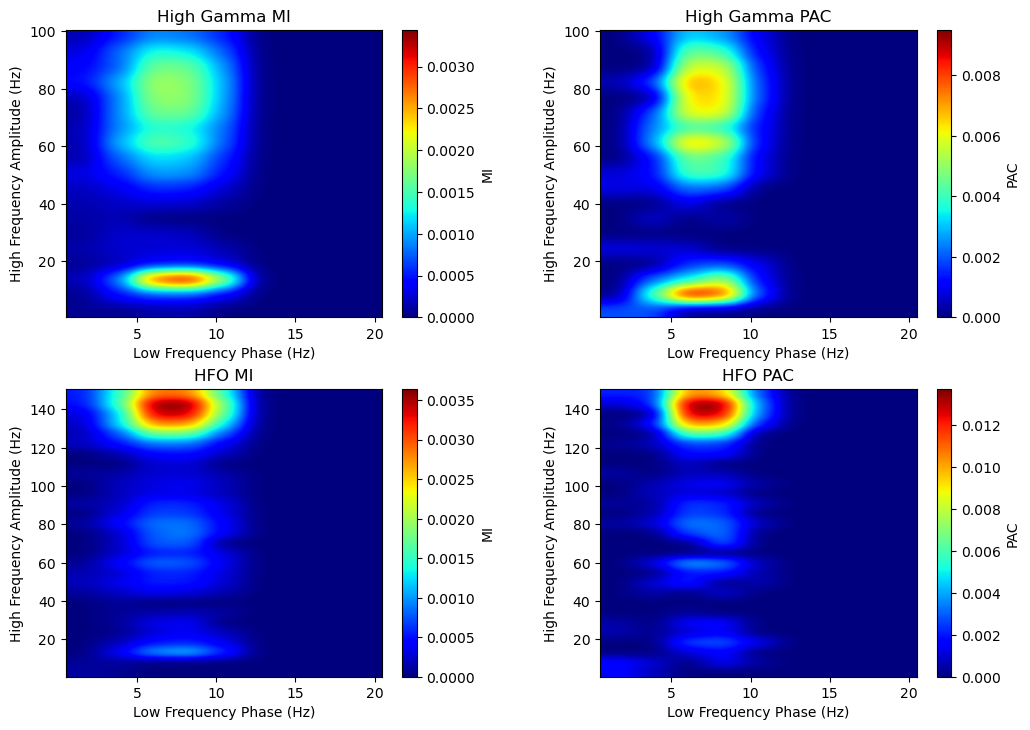

In [236]:
fig,ax = plt.subplots(2,2,figsize=(12,8.4))
ax = ax.flatten()
for i in range(4):
    pvals_holm, bh_idx, k = bh_procedure(pvals_comod[i].flatten(),alpha = 0.05,fPlot = False)
    tmp = np.zeros(comods[i].shape)


    for idx in bh_idx[:k+1]:
        j = idx//comods[i].shape[1]
        k = idx%comods[i].shape[1]
        tmp[j,k] = comods[i].flatten()[idx]
    im = ax[i].imshow(tmp,aspect = 'auto',origin = 'lower',extent =[lband[0],lband[1],hbands[i//2][0],hbands[i//2][1]],interpolation = 'gaussian',cmap = 'jet' )
    ax[i].set_title(names[i])
    print(f'{names[i]}: {np.sum(tmp>0)} significant points')
    #show colorbar
    labels = ['MI','PAC']
    cbar = fig.colorbar(im, ax=ax[i],label = labels[i%2])
    #change wspacing
    fig.subplots_adjust(wspace=.4)
    fig.subplots_adjust(hspace=.25)
    ax[i].set_xlabel('Low Frequency Phase (Hz)')
    ax[i].set_ylabel('High Frequency Amplitude (Hz)')
plt.savefig('../gammaPAC/testing/Figures/comod_bh_sig.svg')

fig,ax = plt.subplots(2,2,figsize=(12,8.4))
ax = ax.flatten()
for i in range(4):
    pvals_holm, holm_idx, k = holm_procedure(pvals_comod[i].flatten(),alpha = 0.05,fPlot = False)
    tmp = np.zeros(comods[i].shape)


    for idx in holm_idx[:k+1]:
        j = idx//comods[i].shape[1]
        k = idx%comods[i].shape[1]
        tmp[j,k] = comods[i].flatten()[idx]
    im = ax[i].imshow(tmp,aspect = 'auto',origin = 'lower',extent =[lband[0],lband[1],hbands[i//2][0],hbands[i//2][1]],interpolation = 'gaussian',cmap = 'jet' )
    ax[i].set_title(names[i])
    print(f'{names[i]}: {np.sum(tmp>0)} significant points')
    #show colorbar
    labels = ['MI','PAC']
    cbar = fig.colorbar(im, ax=ax[i],label = labels[i%2])
    #change wspacing
    fig.subplots_adjust(wspace=.35)
    fig.subplots_adjust(hspace=.25)
    ax[i].set_xlabel('Low Frequency Phase (Hz)')
    ax[i].set_ylabel('High Frequency Amplitude (Hz)')
plt.savefig('../gammaPAC/testing/Figures/comod_holm_sig.svg')